In [1]:
!ls ../input/resnet200d-320-fold0-step3/resnet200d_320_fold0_best_score.pth
!cp ../input/resnet200d-320-fold0-step3/resnet200d_320_fold0_best_score.pth  ./resnet200d_320_fold0_start.pth 

../input/resnet200d-320-fold0-step3/resnet200d_320_fold0_best_score.pth


In [2]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=3f8e4a06b9d9d2517fa8100677875d53e2daf8e82f94596970322bfa030c0573
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [3]:
import sys
sys.path.append ('../input/pytorch-images-seresnet')

import os
import gc
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import AdamW, get_cosine_schedule_with_warmup

from   fastai.losses import LabelSmoothingCrossEntropy

# from warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

import timm
import albumentations as A
from   albumentations import *
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
from   GPUtil import showUtilization as gpu_usage
from   numba import cuda
import warnings
warnings.filterwarnings ("ignore")

In [4]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 4
    model_name   = 'resnet200d_320'  # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 640               # [64, 128, 224, 384, 512, 640, 720]
    isTrain      = True
    isFreeze     = True
    lr           = 5e-4
    epochs       = 1
    warmup_steps = 0.25              # if float: these many epochs are with frozen model at the beginning, if int = actual steps
    epochsNx     = 1
    criterion    = 'BCEWithLogitsLoss'     # ['CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    seed         = 42
    n_fold       = 50
    train_fold   = [0]                      # [0, 1, 2, 3, 4]
    print_every  = 100
    adam_epsilon = 1e-8
    train_batch_size = 12
    eval_batch_size  = 118
    img_ext      = '.jpg'
    img_col      = "StudyInstanceUID"
    label_cols   = [
                    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                    'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                    'Swan Ganz Catheter Present'
    ]
    target_size      = len (label_cols)
    model_infer_path_prefix = "."
    model_train_path_prefix = "."
    train_path       = '../input/ranzcr-clip-catheter-line-classification/train'
    train_csv        = '../input/ranzcr-clip-catheter-line-classification/train.csv'
    test_path        = '../input/ranzcr-clip-catheter-line-classification/test'
    test_csv         = '../input/ranzcr-clip-catheter-line-classification/sample_submission.csv'    
    output_dir       = './results'        # output directory    
    eval_steps       = 0 #500
    max_steps        = 0
    IMG_MEAN         = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD          = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]

In [5]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [6]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Augmentation Dataset

In [7]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
light_transforms = A.Compose ([
    A.Resize (CFG.size, CFG.size),
    A.HorizontalFlip (p=0.5),
    A.HueSaturationValue (hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast (brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
    A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
    A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.CoarseDropout(p=0.5),
    A.Normalize (),
    ToTensorV2 (p=1.0),
])

heavy_transforms = A.Compose ([
    A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.9, 1), p=1), 
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.CLAHE(clip_limit=(1,4), p=0.5),
    A.OneOf([
       A.OpticalDistortion(distort_limit=1.0),
       A.GridDistortion(num_steps=5, distort_limit=1.),
       A.ElasticTransform(alpha=3),
    ], p=0.2),
    A.OneOf([
       A.GaussNoise(var_limit=[10, 50]),
       A.GaussianBlur(),
       A.MotionBlur(),
       A.MedianBlur(),
    ], p=0.2),
    A.Resize(CFG.size, CFG.size),
    A.OneOf([
      JpegCompression(),
      Downscale(scale_min=0.1, scale_max=0.15),
    ], p=0.2),
    IAAPiecewiseAffine(p=0.2),
    IAASharpen(p=0.2),
    A.Cutout(max_h_size=int(CFG.size * 0.1), max_w_size=int(CFG.size * 0.1), num_holes=5, p=0.5),
    A.Normalize(),
    ToTensorV2 (p=1.0),
])

valid_transforms = A.Compose ([
    A.Resize (CFG.size, CFG.size),
    A.Normalize (),
    ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return light_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [8]:
class ImgDataset (Dataset):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super ().__init__()
        self.df               = df.reset_index (drop=True)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        file_name = self.df[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)                              #;print (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.df.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [9]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

10

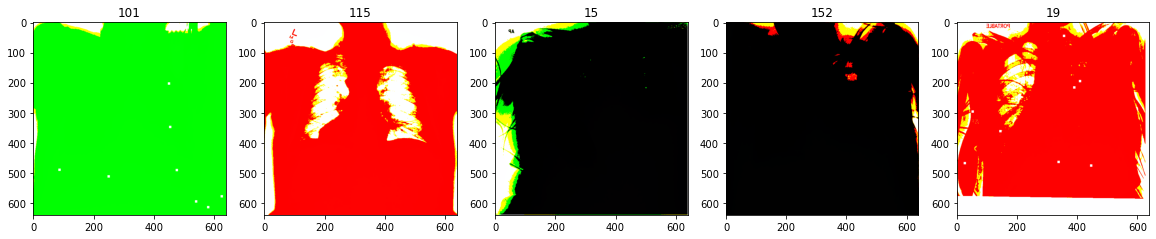

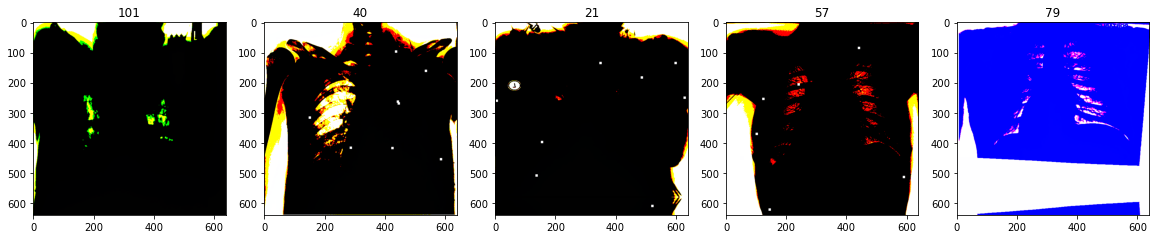

In [10]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                         # ;print (img.size()) ;print (label)
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [11]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [12]:
def get_criterion (class_wt):
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss (pos_weight=class_wt)
    return criterion

In [13]:
class ResNet200D (nn.Module):
    
    def __init__(self, model_name='resnet200d_320'):
        
        super().__init__()
        self.model = timm.create_model (model_name, pretrained=False)
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity ()
        self.model.fc = nn.Identity ()
        self.pooling = nn.AdaptiveAvgPool2d (1)
        self.fc = nn.Linear (n_features, 11)

    def forward(self, x):
        
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters ():
            param.requires_grad = False

        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        # Unfreeze all layers
        for param in self.model.parameters ():
            param.requires_grad = True
        for param in self.fc.parameters ():
            param.requires_grad = True
        return

In [14]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['model']
        # print (state_dict)
        model.load_state_dict (state_dict) # (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [15]:
def getModel (fold, isTrain=True):
    
    model = ResNet200D ()
    if isTrain:
        
        # TODO: _infer_ to _train_,   _end to _maxacc
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_start.pth'
        print ("loading", model_path)
        load_state (model_path, model)        
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.isFreeze:        
        model.freeze ()
    # else:
    #     model.unfreeze ()
    return model

## Helpers

In [16]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

In [17]:
def sigmoid (x):  
    return np.exp (-np.logaddexp (0, -x))

def compute_metrics (labels, pred_pr):
    
    preds   = pred_pr.argmax (-1)             #;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    auc     = -1
    try:
        auc = roc_auc_score (labels, pred_pr[:, 1])
    except:
        pass
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        'auc'      : auc
    }
    return metrics

def compute_multilabel_binary_metrics (labels, logits):
    
    pred_pr = sigmoid (logits)    
    metrics = []
    n_class = labels.shape[1]
    for i in range (n_class):
        
        label  = labels[:, i]
        prob1  = pred_pr[:, i]
        prob0  = 1 - prob1
        pred_p = np.hstack ((prob0.reshape ((-1, 1)), prob1.reshape ((-1, 1))))
        scores = compute_metrics (label, pred_p)
        metrics.append (scores)
        
    # Now Avg over each classes
    metrics_df = pd.DataFrame (metrics)  
    auc = list (metrics_df['auc'].values)
    auc = np.mean ([a for a in auc if a >= 0])
    metrics_df.drop (columns=['auc'], inplace=True)
    metrics_df = metrics_df.mean ()
    metrics_df['auc'] = auc
    return metrics_df.to_dict ()

In [18]:
class MyTrainer:
    
    def __init__(self, fold, model, train_dataset, eval_dataset, criterion, compute_metrics=compute_multilabel_binary_metrics):
        
        if CFG.isFreeze:
            model.freeze ()
        else:
            model.unfreeze ()
        
        self.fold            = fold
        self.model           = model.to (CFG.device)
        self.train_dataset   = train_dataset
        self.eval_dataset    = eval_dataset
        self.criterion       = criterion
        self.compute_metrics = compute_metrics
        self.isTrained       = False
        self.device          = CFG.device
        self.optimizer       = AdamW (model.parameters (), lr=CFG.lr, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
        self.epochs          = CFG.epochs
        self.set_dataLoaders ()
        self.training_stats  = []
        return
    
    def set_dataLoaders (self):
        # Create the DataLoaders for our training and validation sets.
        
        batch_size = CFG.train_batch_size            
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = RandomSampler (self.train_dataset)           # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = batch_size,
                    num_workers = CFG.num_workers,
                    pin_memory  = True
        )
        # train_dataloader  = DataLoader (self.train_dataset, batch_size=batch_size) # TODO: comment this
        validation_dataloader = None
        if self.eval_dataset:
            validation_dataloader = DataLoader (
                        self.eval_dataset, 
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = CFG.eval_batch_size,
                        num_workers = CFG.num_workers,
                        pin_memory  = False
            )
            # validation_dataloader  = DataLoader (self.eval_dataset, batch_size=CFG.eval_batch_size) # TODO: comment this
        
        if type (CFG.warmup_steps) is float:
            CFG.warmup_steps = int (CFG.warmup_steps * len (train_dataloader))
        # Total number of training steps is [number of batches] x [number of epochs]
        num_training_steps = len (train_dataloader) * self.epochs        
        lr_scheduler = get_cosine_schedule_with_warmup (self.optimizer, 
                        num_warmup_steps   = CFG.warmup_steps,
                        num_training_steps = num_training_steps)
        
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps = train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
        return
            
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    
    def train (self):
        
        seed_everything (seed=CFG.seed)
        min_val_loss     = 9999
        min_train_loss   = 9999
        max_val_auc      = -1
        step             = 0
        total_t0         = time.time ()
        self.training_stats = []
        for epoch_i in range (0, self.epochs):
            
            avg_epoch_train_loss   = 0
            total_epoch_train_loss = 0
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            t0 = time.time ()
            self.model.train ()
            for stp, batch in tqdm (enumerate (self.train_dataloader), total=len(self.train_dataloader)):
                ########################################################
                # Print Stats
                ########################################################
                # if step % CFG.print_every == 0:
                #     elapsed = format_time (time.time() - t0)
                #     print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format (step, len (self.train_dataloader), elapsed))
                
                if (CFG.max_steps > 0 and CFG.max_steps < step) or (CFG.eval_steps>0 and step % CFG.eval_steps==0):
                    
                    training_time = format_time (time.time () - t0)                    
                    if self.validation_dataloader:
                        
                        avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                        # save this model if the eval loss decreases from the minimum so far
                        if avg_val_loss < min_val_loss: 
                            
                            min_val_loss = avg_val_loss
                            torch.save (self.model.state_dict (), f"{CFG.model_train_path_prefix}/{CFG.model_name}_fold{self.fold}_min_val_loss.pth")
                    if CFG.max_steps > 0 and CFG.max_steps < step:
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        try:
                            self.plot_train_stats (self.training_stats)
                        except:
                            pass
                        return self.training_stats
                
                ########################################################
                # Train
                ########################################################
                self.model.zero_grad ()                        
                images = batch[0].to (self.device)
                labels = batch[1].to (self.device)
                # gpu_usage ()
                logits = self.model (images)
                loss   = self.criterion (logits, labels)
                torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                loss.backward ()
                self.optimizer.step ()
                self.lr_scheduler.step ()
                total_epoch_train_loss += loss.cpu ().item ()
                avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                step += 1
            # all steps of an epoch end
            
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.4f}".format (avg_epoch_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))            
            if self.validation_dataloader:    
                
                avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < min_val_loss:                    
                    min_val_loss = avg_val_loss
                    torch.save (self.model.state_dict (), f"{CFG.model_train_path_prefix}/{CFG.model_name}_fold{self.fold}_min_val_loss.pth")
                if avg_val_auc > max_val_auc:
                    max_val_auc = avg_val_auc
                    torch.save (self.model.state_dict (), f"{CFG.model_train_path_prefix}/{CFG.model_name}_fold{self.fold}_max_val_auc.pth")
            else:                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_epoch_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < min_train_loss:                     
                    min_train_loss = avg_train_loss
                    torch.save (self.model.state_dict (), f"{CFG.model_train_path_prefix}/{CFG.model_name}_fold{self.fold}_min_train_loss.pth")
                    
            torch.save (self.model.state_dict (), f"{CFG.model_train_path_prefix}/{CFG.model_name}_fold{self.fold}_e{epoch_i+1}.pth")
            # 1 epoch end
        # all epochs end
        
        print ("")
        print ("Training complete!")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.model.eval ()
        try:
            self.plot_train_stats (self.training_stats)
        except:
            pass
        return pd.DataFrame (self.training_stats)
    
    
    def evaluate (self, epoch_i, avg_train_loss=999, training_time=999):
        
        t0 = time.time ()
        
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_auc       = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                images = batch[0].to (self.device)
                labels = batch[1].to (self.device)
                logits = self.model (images)
                loss   = self.criterion (logits, labels).cpu ().detach ()
                labels = labels.cpu ()
                
            total_eval_loss += loss.item ()
            logits     = logits.cpu ().detach ().numpy ()            
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            metrics               = self.compute_metrics (labels, logits)
            total_eval_mcc       += metrics['mcc']
            total_eval_f1        += metrics['f1']
            total_eval_precision += metrics['precision']
            total_eval_recall    += metrics['recall']
            total_eval_auc       += metrics['auc']
            total_eval_accuracy  += metrics['accuracy']
        # epoch end
        
        # Report the final accuracy for this validation run.
        avg_val_f1 = total_eval_f1 / len (self.validation_dataloader)
        print ("  F1: {0:.4f}".format (avg_val_f1))
        avg_val_mcc = total_eval_mcc / len (self.validation_dataloader)
        print ("  MCC: {0:.4f}".format (avg_val_mcc))
        avg_val_precision = total_eval_precision / len (self.validation_dataloader)
        print ("  Precision: {0:.4f}".format (avg_val_precision))
        avg_val_recall = total_eval_recall / len (self.validation_dataloader)
        print ("  Recall: {0:.4f}".format (avg_val_recall))
        avg_val_auc = total_eval_auc / len (self.validation_dataloader)
        print ("  AUC: {0:.4f}".format (avg_val_auc))
        avg_val_accuracy = total_eval_accuracy / len (self.validation_dataloader)
        print ("  Accuracy: {0:.4f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        print ("  Validation Loss: {0:.4f}".format (avg_val_loss))
        print ("  Validation took: {:}".format (validation_time))
        
        self.training_stats.append ({
                'epoch'         : epoch_i + 1,
                'training_loss' : avg_train_loss,
                'eval_loss'     : avg_val_loss,
                'eval_f1'       : avg_val_f1,
                'eval_mcc'      : avg_val_mcc, 
                'eval_precision': avg_val_precision,
                'eval_recall'   : avg_val_recall,
                'eval_auc'      : avg_val_auc, 
                'eval_accuracy' : avg_val_accuracy,
                'training_time' : training_time,
                'eval_time'     : validation_time                   
        })
        self.model.train ()
        print ("Validation took {:} (h:mm:ss)".format (format_time (time.time () - t0)))
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        mccs   = accuracies = f1_scores = precisions = recalls = auc = losses = epochs = -1
        epochs = len (training_stats)
        if 'eval_mcc' in training_stats[0]:
            mccs       = [e['eval_mcc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_f1' in training_stats[0]:
            f1_scores  = [e['eval_f1'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        if 'eval_precision' in training_stats[0]:
            precisions = [e['eval_precision'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        if 'eval_recall' in training_stats[0]:
            recalls    = [e['eval_recall'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        if 'eval_auc' in training_stats[0]:
            auc        = [e['eval_auc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_auc')
        if 'eval_loss' in training_stats[0]:
            losses     = [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('mccs       :', mccs)
        print ('accuracies :', accuracies)
        print ('precisions :', precisions)
        print ('recalls    :', recalls)
        print ('f1_scores  :', f1_scores)
        print ('auc        :', auc)
        print ('losses     :', losses)
        print ('tr_losses  :', tr_losses)
        
        
        plt.plot (recalls, precisions, marker='.', label='Prcision-Recall Curve')
        # axis labels
        plt.xlabel ('Recall')
        plt.ylabel ('Precision')
        # show the legend
        plt.legend ()
        # show the plot
        plt.show ()
        return
    
    
    def getTrainedModel (self):
        
        if self.isTrained:
            return self.model
        return None

In [19]:
def free_gpu_cache ():
    
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
    return

# free_gpu_cache()           

## Train

In [20]:
def train_fold_loop (fold, train_df):

    print (f"========== fold: {fold} training ==========")

    trn_idx        = train_df[train_df['fold'] != fold].index
    val_idx        = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True) 
    class_wt       = 1 / (1 + np.array (train_df[CFG.label_cols].sum (axis=0).values))
    class_wt       = torch.tensor (class_wt / np.sum (class_wt)).to (CFG.device)   ;print ('class_wt =', class_wt)
    class_wt       = class_wt.to (CFG.device)
    
    criterion      = get_criterion (class_wt=class_wt)
    model          = getModel (fold, isTrain=True)
    model          = model.float()
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))    
    trainer        = MyTrainer (
        fold            = fold,
        model           = model,
        train_dataset   = train_dataset,
        eval_dataset    = valid_dataset,
        criterion       = criterion,
        compute_metrics = compute_multilabel_binary_metrics,
    )
    metrics = trainer.train ()
    return metrics

In [21]:
def train_main ():
    
    print (f"========== train_main() ==========")
    train_df = getFolds ()
    if CFG.isTrain:        
        valid_scores_df = pd.DataFrame ()
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                
                valid_scores_fold_df = train_fold_loop (fold, train_df)
                # valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores_df = valid_scores_df.append (valid_scores_fold_df)
                
        print (f"========== CV ==========")
        print (valid_scores_df)
        # valid_scores = np.vstack (valid_scores)
        # valid_scores = np.mean (valid_scores, axis=0)
        valid_scores = valid_scores_df.mean ()
        print ("CV Scores :-");  print (valid_scores)
    return

========== train_main() ==========
========== fold: 0 training ==========
class_wt = tensor([0.5888, 0.0414, 0.0065, 0.1682, 0.0889, 0.0171, 0.0098, 0.0147, 0.0056,
        0.0022, 0.0567], device='cuda:0', dtype=torch.float64)
loading ./resnet200d_320_fold0_start.pth
======== Epoch 1 / 1 ========


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]

  Average training loss: 0.0071
  Training epcoh took: 0:00:19


  F1: 0.5653
  MCC: 0.1872
  Precision: 0.6327
  Recall: 0.5965
  AUC: 0.9029
  Accuracy: 0.8621
  Validation Loss: 0.0101
  Validation took: 0:00:26
Validation took 0:00:26 (h:mm:ss)

Training complete!
Total training took 0:00:47 (h:mm:ss)


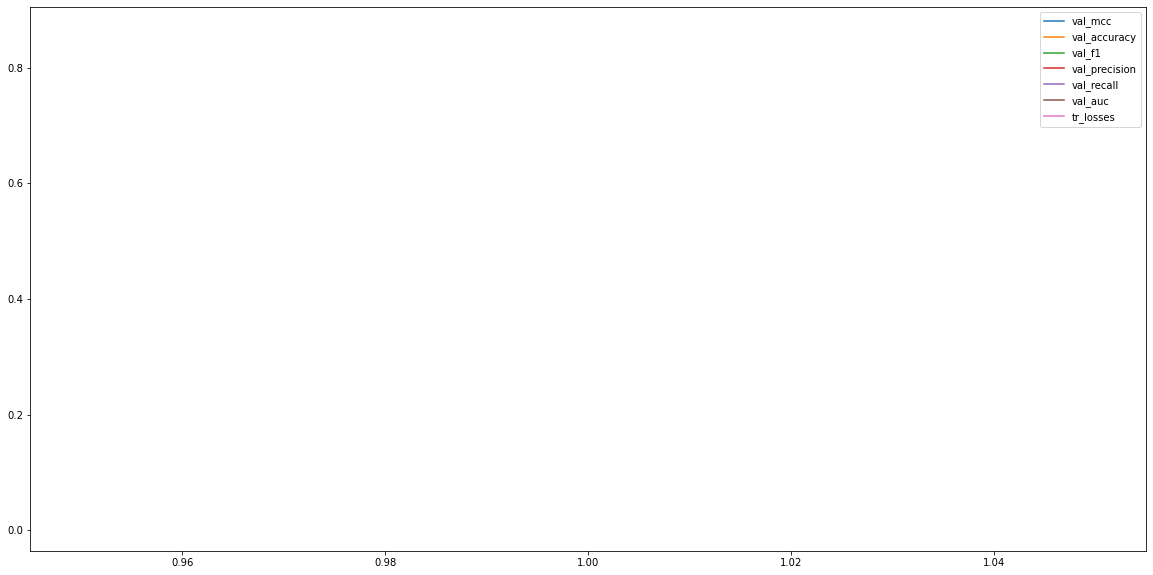

mccs       : [0.18716523663390588]
accuracies : [0.8621425081739262]
precisions : [0.6326861278539324]
recalls    : [0.5964565272749416]
f1_scores  : [0.565317290426422]
auc        : [0.9028895922230462]
losses     : [0.010091828648000956]
tr_losses  : [0.007125596296699608]


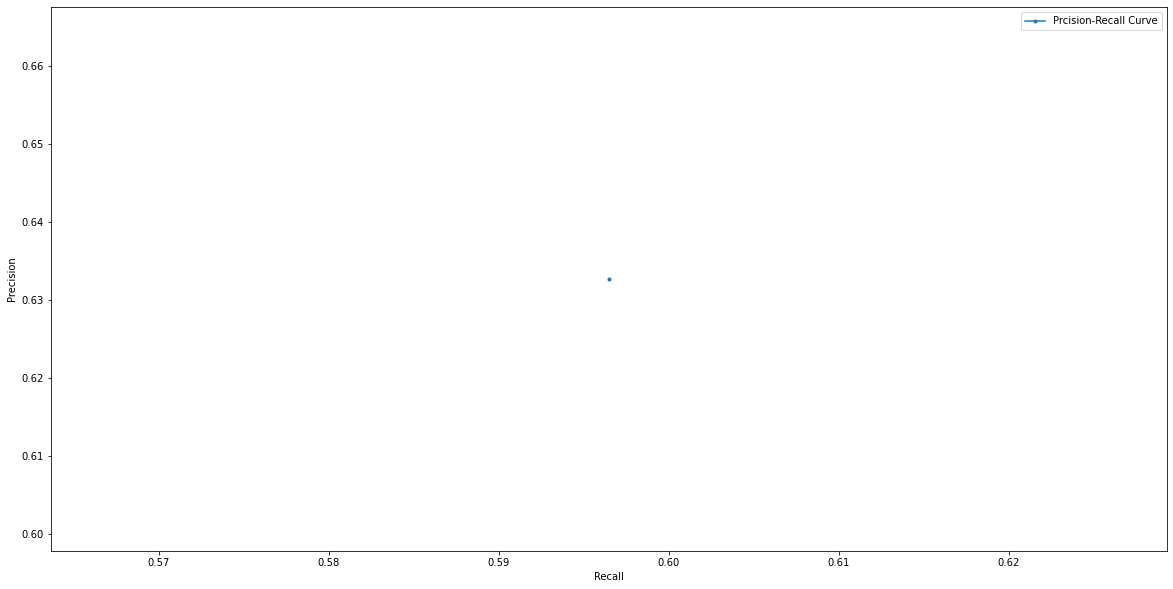

========== CV ==========
   epoch  training_loss  eval_loss   eval_f1  eval_mcc  eval_precision  \
0      1       0.007126   0.010092  0.565317  0.187165        0.632686   

   eval_recall  eval_auc  eval_accuracy training_time eval_time  
0     0.596457   0.90289       0.862143       0:00:19   0:00:26  
CV Scores = epoch             1.000000
training_loss     0.007126
eval_loss         0.010092
eval_f1           0.565317
eval_mcc          0.187165
eval_precision    0.632686
eval_recall       0.596457
eval_auc          0.902890
eval_accuracy     0.862143
dtype: float64


In [22]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*resnet*', pretrained=True)
# pprint (model_names)
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)

train_main ()

In [23]:
print ('Done !')

Done !
